In [1]:
#install pyspark
!pip install pyspark


In [2]:
#install findspark
!pip install findspark

In [2]:
#spark connection
import findspark
findspark.init()
import pyspark
from pyspark.context import SparkContext
from pyspark.sql import SparkSession
sc = SparkContext.getOrCreate()
spark = SparkSession.builder.appName('ECE-Finalproject_team11').master('local').config("spark.mongodb.input.uri", "mongodb://127.0.0.1/").config("spark.mongodb.output.uri", "mongodb://127.0.0.1/").config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.11:2.4.1').getOrCreate()
print(sc.version)
print(spark.version)

3.5.1
3.5.1


In [3]:
#import libraries
from pyspark.sql import Row
import numpy as np
import pandas as pd
from pyspark.sql.types import *
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
from pyspark.sql import functions as fn
from pyspark.ml import feature, regression, evaluation, Pipeline
import seaborn as sns
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt


In [4]:
#Loading data from csv
accidents_df = spark.read.option("sep", ",").option("header", "true").csv("/Users/ravitejaadabala/Documents/GMU/SEM3/ECE552/Project/US_Accidents_Dec21.csv")

In [5]:
accidents_df.show(4)

+---+--------+-----------+------------+---------+---------+--------+---------+--------------+--------------------+------+-----------+----+----------+----------+-----+-------+-------+----------+------------+-----------------+-----------+----------+--------+--------+----------+--------------+----------+-------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
| ID|Severity| Start_Time|    End_Time|Start_Lat|Start_Lng| End_Lat|  End_Lng|Distance_in_mi|         Description|Number|     Street|Side|      City|    County|State|Zipcode|Country|  Timezone|Airport_Code|Weather_Timestamp|Temperature|Wind_Chill|Humidity|Pressure|Visibility|Wind_Direction|Wind_Speed|Precipitation|Weather_Condition|Amenity| Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_S

In [6]:
accidents_df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Severity: string (nullable = true)
 |-- Start_Time: string (nullable = true)
 |-- End_Time: string (nullable = true)
 |-- Start_Lat: string (nullable = true)
 |-- Start_Lng: string (nullable = true)
 |-- End_Lat: string (nullable = true)
 |-- End_Lng: string (nullable = true)
 |-- Distance_in_mi: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Number: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- Side: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: string (nullable = true)
 |-- Temperature: string (nullable = true)
 |-- Wind_Chill: string (nullable = true)
 |-- Humidity: string (nullable = true)
 |-- Pressure: string (nullable

In [8]:
# converting to parquet and reading from parquet

accidents_df.write.parquet("usaccidents.parquet")

parquetaccidents = spark.read.parquet("usaccidents.parquet")

In [9]:
# Shape of the spark dataframe

print('Shape is ',(parquetaccidents.count(),len(parquetaccidents.columns)))

Shape is  (1048575, 47)


In [10]:
# Columns to be dropped initially as a list
drop_col = ['ID','End_Lat','End_Lng','Description','Number','Street','Airport_Code','Country','Weather_Timestamp','Wind_Chill','Turning_Loop']

In [11]:
# Dropping columns from the original dataset

parquetaccidents = parquetaccidents.drop(*(drop_col))

In [12]:
# Checking null values in all the columns

from pyspark.sql.functions import isnan, isnull, when, count, col

parquetaccidents.select([count(when(isnull(c), c)).alias(c) for c in parquetaccidents.columns]).show()

+--------+----------+--------+---------+---------+--------------+----+----+------+-----+-------+--------+-----------+--------+--------+----------+--------------+----------+-------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+--------------+--------------+-----------------+---------------------+
|Severity|Start_Time|End_Time|Start_Lat|Start_Lng|Distance_in_mi|Side|City|County|State|Zipcode|Timezone|Temperature|Humidity|Pressure|Visibility|Wind_Direction|Wind_Speed|Precipitation|Weather_Condition|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Sunrise_Sunset|Civil_Twilight|Nautical_Twilight|Astronomical_Twilight|
+--------+----------+--------+---------+---------+--------------+----+----+------+-----+-------+--------+-----------+--------+--------+----------+--------------+----------+-------------+-----------------+-------+----+--------+--

In [13]:
# Replacing same Wind_Direction named with different string N and North same

parquetaccidents = parquetaccidents.withColumn('Wind_Direction', when(parquetaccidents.Wind_Direction == 'E', 'East')\
                   .when(parquetaccidents.Wind_Direction == 'W', 'West')\
                   .when(parquetaccidents.Wind_Direction == 'N', 'North')\
                   .when(parquetaccidents.Wind_Direction == 'S', 'South')\
                   .when(parquetaccidents.Wind_Direction == 'VAR', 'Variable')\
                   .when(parquetaccidents.Wind_Direction == 'CALM', 'Calm')\
                   .otherwise(parquetaccidents.Wind_Direction))

In [14]:
# Replacing same Weather_Condition named with different string Light Rain Shower and Light Rain Showers same

parquetaccidents = parquetaccidents.withColumn('Weather_Condition', when(parquetaccidents.Weather_Condition == 'Light Rain Shower', 'Light Rain Showers')\
                   .when(parquetaccidents.Weather_Condition == 'Light Snow Shower', 'Light Snow Showers')\
                   .when(parquetaccidents.Weather_Condition == 'Rain Shower', 'Rain Showers')\
                   .otherwise(parquetaccidents.Weather_Condition))

In [15]:
# Dropping Null rows from City Column as there are only 55 rows with City = Null

parquetaccidents = parquetaccidents.where(col("city").isNotNull())

In [16]:
# Dropping Null rows from Timezone Column 

parquetaccidents = parquetaccidents.where(col("Timezone").isNotNull())

In [17]:
# Clipping Temperature extreme values to suppress outliers

lower = -30
upper = 115
parquetaccidents = parquetaccidents.withColumn('Temperature', when(parquetaccidents.Temperature > upper, upper)\
                  .when(parquetaccidents.Temperature < lower, lower).otherwise(parquetaccidents.Temperature).alias('Temperature'))

In [18]:
# Distance > 100 rows dropped
parquetaccidents = parquetaccidents.where(parquetaccidents.Distance_in_mi <=100)

In [19]:
# Clipping Visibility extreme values to suppress outliers 

upper = 20
parquetaccidents = parquetaccidents.withColumn('Visibility', when(parquetaccidents.Visibility > upper, upper)\
                  .otherwise(parquetaccidents.Visibility).alias('Visibility'))

In [20]:
# Clipping Wind_Speed extreme values to suppress outliers 
upper = 40
parquetaccidents = parquetaccidents.withColumn('Wind_Speed', when(parquetaccidents.Wind_Speed > upper, upper)\
                  .otherwise(parquetaccidents.Wind_Speed).alias('Wind_Speed'))

In [21]:
#replacing missing values in categorical attributes with the mode of the corresponding variables

for col_name in ['Wind_Direction', 'Weather_Condition']:
    common = parquetaccidents.dropna().groupBy(col_name).agg(fn.count('*')).orderBy('count(1)', ascending = False).first()[col_name]
    parquetaccidents = parquetaccidents.withColumn(col_name, when(isnull(col_name), common).otherwise(parquetaccidents[col_name]))

In [22]:
#converting string to float 
parquetaccidents=parquetaccidents.withColumn("Temperature",parquetaccidents.Temperature.cast('double'))
parquetaccidents=parquetaccidents.withColumn("Humidity",parquetaccidents.Humidity.cast('double'))
parquetaccidents=parquetaccidents.withColumn("Pressure",parquetaccidents.Pressure.cast('double'))
parquetaccidents=parquetaccidents.withColumn("Visibility",parquetaccidents.Visibility.cast('double'))
parquetaccidents=parquetaccidents.withColumn("Wind_Speed",parquetaccidents.Wind_Speed.cast('double'))
parquetaccidents=parquetaccidents.withColumn("Distance_in_mi",parquetaccidents.Distance_in_mi.cast('double'))

In [23]:
#replacing missing values in numerical attributes with the median of the corresponding variables

for col_name in ['Temperature', 'Humidity', 'Pressure', 'Visibility', 'Wind_Speed']:
    median = parquetaccidents.dropna().approxQuantile(col_name, [0.5], 0.00)[0]
    parquetaccidents = parquetaccidents.withColumn(col_name, when(isnull(col_name), median).otherwise(parquetaccidents[col_name]))

In [24]:
# Replacing Null values in Precipitation with 0

parquetaccidents = parquetaccidents.withColumn('Precipitation', when(parquetaccidents.Precipitation.isNull(), 0).otherwise(parquetaccidents.Precipitation))

In [25]:
# Removing Null values in last 4 columns 

parquetaccidents = parquetaccidents.filter(parquetaccidents.Sunrise_Sunset.isNotNull())

parquetaccidents = parquetaccidents.filter(parquetaccidents.Civil_Twilight.isNotNull())

parquetaccidents = parquetaccidents.filter(parquetaccidents.Nautical_Twilight.isNotNull())
 
parquetaccidents = parquetaccidents.filter(parquetaccidents.Astronomical_Twilight.isNotNull())

In [26]:
# Adding Month of Year, Day of Week , Week of Year and Hour of the Day Column from Start Time

parquetaccidents = parquetaccidents.withColumn("Start_Time",to_timestamp(col('Start_Time'),'MM/dd/yy HH:mm')).withColumn("month_of_year", date_format(col("Start_Time"), "MMMM")).withColumn("day_of_week", date_format(col("Start_Time"), "EEEE")).withColumn("hour_day", date_format(col("Start_Time"), "H")).withColumn("week_of_year", date_format(col("Start_Time"), "w")).withColumn("Year", date_format(col("Start_Time"), "YYYY"))


In [27]:
#dropping null values from time related cloumns
parquetaccidents = parquetaccidents.filter(parquetaccidents.Start_Time.isNotNull())

In [36]:
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

In [37]:
# Checking null values in all the columns

from pyspark.sql.functions import isnan, isnull, when, count, col

parquetaccidents.select([count(when(isnull(c), c)).alias(c) for c in parquetaccidents.columns]).show()

+--------+----------+--------+---------+---------+--------------+----+----+------+-----+-------+--------+-----------+--------+--------+----------+--------------+----------+-------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+--------------+--------------+-----------------+---------------------+-------------+-----------+--------+------------+----+
|Severity|Start_Time|End_Time|Start_Lat|Start_Lng|Distance_in_mi|Side|City|County|State|Zipcode|Timezone|Temperature|Humidity|Pressure|Visibility|Wind_Direction|Wind_Speed|Precipitation|Weather_Condition|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Sunrise_Sunset|Civil_Twilight|Nautical_Twilight|Astronomical_Twilight|month_of_year|day_of_week|hour_day|week_of_year|Year|
+--------+----------+--------+---------+---------+--------------+----+----+------+-----+-------+--------+-----------+-----

In [ ]:
# Mongodb integration
# writing to mongodb
parquetaccidents.write.format('mongo')\
        .mode("overwrite")\
        .option( "uri", "mongodb://localhost:27018/ece552_team11.accident_data") \
        .save()

In [ ]:
# reading from mongodb
mongo_df = spark.read.format("mongo").option( "uri", "mongodb://localhost:27018").option("database","ece552_team11").option("collection", "accident_data").load()
mongo_df.show(5)

+-------+---------------------+-----+-----------+--------------+----------+--------+--------------+--------------+--------+--------+--------+-----------------+-------+-------------+--------+-------+----------+--------+----+---------+-----------+-------------------+-----+-------+-----+--------------+-----------+-----------+---------------+--------------+----------+--------------------+--------------+----------+----+----------+--------------------+-----------+--------+-------------+------------+
|Amenity|Astronomical_Twilight| Bump|       City|Civil_Twilight|    County|Crossing|Distance_in_mi|      End_Time|Give_Way|Humidity|Junction|Nautical_Twilight|No_Exit|Precipitation|Pressure|Railway|Roundabout|Severity|Side|Start_Lat|  Start_Lng|         Start_Time|State|Station| Stop|Sunrise_Sunset|Temperature|   Timezone|Traffic_Calming|Traffic_Signal|Visibility|   Weather_Condition|Wind_Direction|Wind_Speed|Year|   Zipcode|                 _id|day_of_week|hour_day|month_of_year|week_of_year|
+-

# Exploratory Data Analysis

In [39]:
pc1=parquetaccidents.groupBy('State').count()


In [40]:
pc1=pc1.sort(col('Count').desc())

In [41]:
pc2=parquetaccidents.groupBy('City').count()

In [42]:
pc2=pc2.sort(col('Count').desc())

In [43]:
pc2.show(10)

+-----------+-----+
|       City|count|
+-----------+-----+
|      Miami|38929|
|    Orlando|21476|
|Los Angeles|19595|
|     Dallas|15442|
|    Houston|14839|
|  Charlotte|13044|
| Sacramento| 8953|
|  San Diego| 8489|
|    Raleigh| 7608|
|  Nashville| 7084|
+-----------+-----+
only showing top 10 rows



### Which State and City recorded the maximum number of accidents?

In [44]:
pc1= pc1.limit(10).toPandas()

In [45]:
pc2= pc2.limit(10).toPandas()

<AxesSubplot:title={'center':'Top 10 US States with the Highest Number of Accidents'}, xlabel='State'>

Text(0, 0.5, 'Number of Accidents')

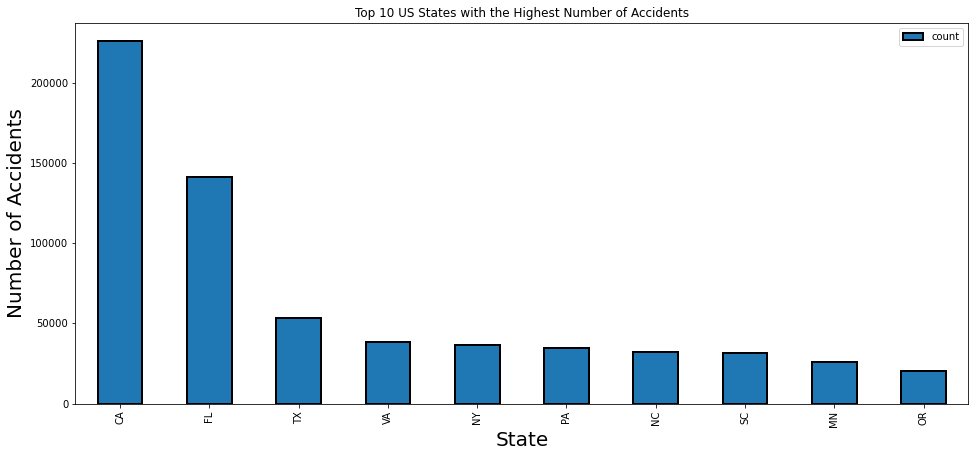

In [46]:
display(pc1.plot.bar(x='State',y='count',width=0.5,edgecolor='k',align='center',linewidth=2,title='Top 10 US States with the Highest Number of Accidents',figsize=(16,7)))
plt.xlabel('State',fontsize=20)
plt.ylabel('Number of Accidents',fontsize=20)

<AxesSubplot:title={'center':'Top 10 US Cities with the Highest Number of Accidents'}, xlabel='City'>

Text(0, 0.5, 'Number of Accidents')

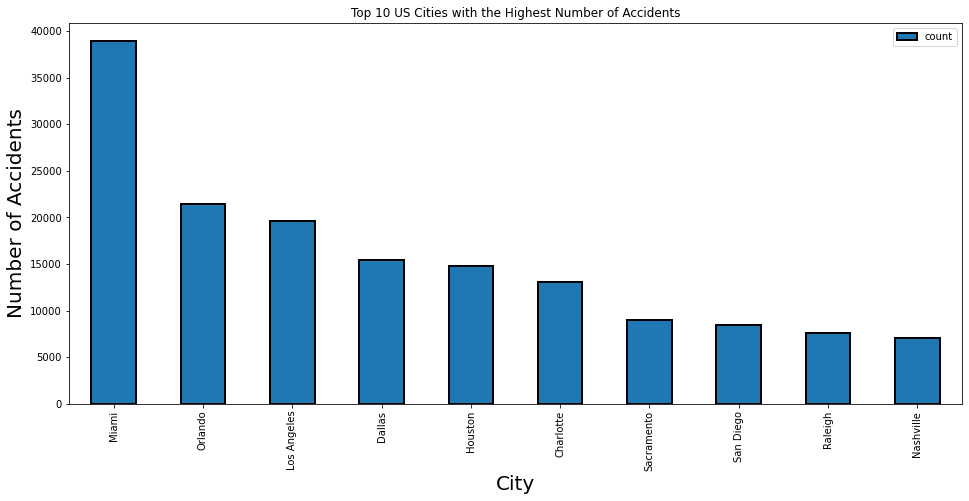

In [47]:
display(pc2.plot.bar(x='City',y='count',width=0.5,edgecolor='k',align='center',linewidth=2,title='Top 10 US Cities with the Highest Number of Accidents',figsize=(16,7)))
plt.xlabel('City',fontsize=20)
plt.ylabel('Number of Accidents',fontsize=20)


### Which month or year had how many accidents and if there is a trend or a pattern?

In [48]:
pc3=parquetaccidents.groupBy('Severity','month_of_year').count()

In [49]:
pc3=pc3.sort(col('Count').desc())

In [50]:
pc3.show(10)

+--------+-------------+------+
|Severity|month_of_year| count|
+--------+-------------+------+
|       2|     December|147875|
|       2|     November|105865|
|       2|      October| 84983|
|       2|    September| 77075|
|       2|         June| 75395|
|       2|         July| 72567|
|       2|       August| 71309|
|       2|          May| 56200|
|       2|        April| 49188|
|       2|        March| 45995|
+--------+-------------+------+
only showing top 10 rows



In [51]:
pc3= pc3.limit(10).toPandas()

pc3.head(10)

<AxesSubplot:title={'center':'Monthly Accidents count for severity level 2'}, xlabel='month_of_year'>

Text(0, 0.5, 'Number of Accidents')

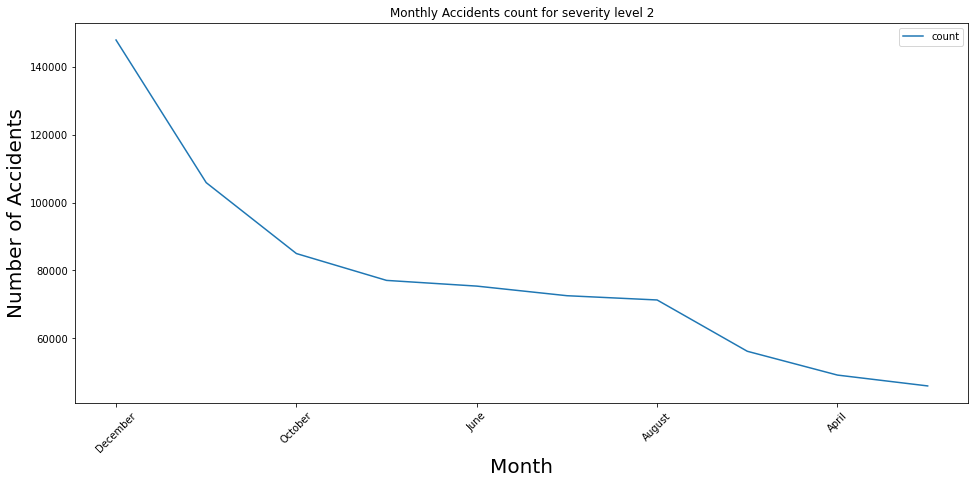

In [52]:
display(pc3.plot.line(x='month_of_year',y='count',title='Monthly Accidents count for severity level 2',figsize=(16,7)))
plt.xticks(rotation=45)
plt.xlabel('Month',fontsize=20)
plt.ylabel('Number of Accidents',fontsize=20)

## Year wise count

In [53]:
pc4=parquetaccidents.groupBy('Year').count()

In [54]:
pc4=pc4.sort(col('count').desc())

In [55]:
pc4.show(3)

+----+------+
|Year| count|
+----+------+
|2021|637546|
|2016|121919|
|2017|102842|
+----+------+
only showing top 3 rows



## Percentage distribution of severity

In [56]:
pc5=parquetaccidents.groupBy('Severity').count()

In [57]:
pc5=pc5.sort(col('count').desc())

In [58]:
pc5.show()

+--------+------+
|Severity| count|
+--------+------+
|       2|809360|
|       3| 39963|
|       4| 39138|
+--------+------+



In [59]:
pc5= pc5.limit(5).toPandas()

In [60]:
pc5.head(5)

,Severity,count
0,2,809360
1,3,39963
2,4,39138


In [61]:
pc5=pc5.set_index('Severity')

<AxesSubplot:title={'center':'Severity level distribution'}, ylabel='Severity'>

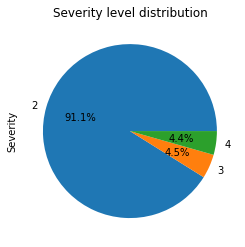

In [62]:
pc5['count'].plot.pie(autopct='%1.1f%%',shadow=False,label='Severity',title='Severity level distribution')

# Daily accident counts showing distribiution of accidents on 7 days of the week

In [63]:
pc6=parquetaccidents.groupBy('day_of_week').count()

In [64]:
pc6=pc6.sort(col('count').desc())

In [65]:
pc6.show()

+-----------+------+
|day_of_week| count|
+-----------+------+
|     Friday|157983|
|   Thursday|146045|
|  Wednesday|145424|
|    Tuesday|141861|
|     Monday|130827|
|   Saturday| 91551|
|     Sunday| 74770|
+-----------+------+



In [66]:
pc6= pc6.limit(10).toPandas()

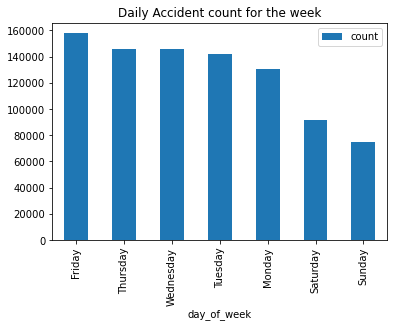

In [67]:
pc6.plot(kind='bar',x='day_of_week',y='count',title='Daily Accident count for the week')
display()

### Accident distribution based on time of the day

In [68]:
pc7=parquetaccidents.groupBy('Sunrise_Sunset','Severity').count()
pc8=parquetaccidents.groupBy('Civil_Twilight','Severity').count()
pc9=parquetaccidents.groupBy('Nautical_Twilight','Severity').count()
pc10=parquetaccidents.groupBy('Astronomical_Twilight','Severity').count()

In [69]:
pc7=pc7.sort(col('Count').desc())
pc8=pc8.sort(col('Count').desc())
pc9=pc9.sort(col('Count').desc())
pc10=pc10.sort(col('Count').desc())

In [70]:
pc7.show(6)

+--------------+--------+------+
|Sunrise_Sunset|Severity| count|
+--------------+--------+------+
|           Day|       2|574820|
|         Night|       2|234540|
|           Day|       3| 26353|
|           Day|       4| 22926|
|         Night|       4| 16212|
|         Night|       3| 13610|
+--------------+--------+------+



In [71]:
pc8.show(6)

+--------------+--------+------+
|Civil_Twilight|Severity| count|
+--------------+--------+------+
|           Day|       2|610202|
|         Night|       2|199158|
|           Day|       3| 28097|
|           Day|       4| 24499|
|         Night|       4| 14639|
|         Night|       3| 11866|
+--------------+--------+------+



In [72]:
pc9.show(6)

+-----------------+--------+------+
|Nautical_Twilight|Severity| count|
+-----------------+--------+------+
|              Day|       2|650235|
|            Night|       2|159125|
|              Day|       3| 29971|
|              Day|       4| 26228|
|            Night|       4| 12910|
|            Night|       3|  9992|
+-----------------+--------+------+



In [73]:
pc10.show(6)

+---------------------+--------+------+
|Astronomical_Twilight|Severity| count|
+---------------------+--------+------+
|                  Day|       2|682487|
|                Night|       2|126873|
|                  Day|       3| 31755|
|                  Day|       4| 27951|
|                Night|       4| 11187|
|                Night|       3|  8208|
+---------------------+--------+------+



## Data Modelling

In [74]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
spark = SparkSession.builder.getOrCreate()
from sklearn.metrics import classification_report
sc = spark.sparkContext
from pyspark.ml import Pipeline
from pyspark.ml.feature import  StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression

In [75]:
parq_acc_modelling = parquetaccidents

In [76]:
#converting string to float 
parq_acc_modelling=parq_acc_modelling.withColumn("Year",parq_acc_modelling.Year.cast('int'))
parq_acc_modelling=parq_acc_modelling.withColumn("Precipitation",parq_acc_modelling.Precipitation.cast('float'))
parq_acc_modelling=parq_acc_modelling.withColumn("hour_day",parq_acc_modelling.hour_day.cast('int'))
parq_acc_modelling=parq_acc_modelling.withColumn("week_of_year",parq_acc_modelling.week_of_year.cast('int'))


In [77]:
# Dropping column Start time,end time, timezone, start latitude and end latitude as they won't be helpful in predicting
# the severiy of the accident
# The columns city, county and state have high cardinality so we have dropped them
drop_col=["Start_Time","End_Time","Start_Lat","Start_Lng",'City','County','State','Timezone','Zipcode','Weather_Condition','month_of_year','day_of_week']

In [78]:
#Dropping the columns 
parq_acc_modelling = parq_acc_modelling.drop(*(drop_col))

In [79]:
# As the data contains very few rows (around 300 in 1 million rows) of Severity 1 we have converted it to Severity 2 because 
# both the classes indicate accidents with less severity 
parq_acc_modelling=parq_acc_modelling.withColumn("Severity",when(parq_acc_modelling["Severity"]==1,2).otherwise(parq_acc_modelling["Severity"]))

In [80]:
#list of all categorical columns
categorical_columns=['Side','Wind_Direction','Sunrise_Sunset','Civil_Twilight',
                     'Nautical_Twilight','Astronomical_Twilight']

In [81]:
#encoding the categrical column as models do not accept string
stages = []

#iterate through all categorical values
for categoricalCol in categorical_columns:
    #create a string indexer for those categorical values and assign a new name including the word 'Index'
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + '_Index')

    #append the string Indexer to our list of stages
    stages += [stringIndexer]

In [82]:
# Running the pipeline which encodes the categorical column

pipeline = Pipeline(stages = stages)
#fit the pipeline to our dataframe
pipelineModel = pipeline.fit(parq_acc_modelling)
#transform the dataframe
parq_acc_modelling= pipelineModel.transform(parq_acc_modelling)

In [83]:
# Dropping the original categorical column
parq_acc_modelling=parq_acc_modelling.drop(*(categorical_columns))

In [84]:
#List of columns with binary values i.e. True/False

binary_columns=['Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop',
'Traffic_Calming','Traffic_Signal']

In [85]:
# Converts the binary values into 0/1
import pyspark.sql.functions as F
from functools import reduce
for i in binary_columns:
    parq_acc_modelling=parq_acc_modelling.withColumn(i, F.when(parq_acc_modelling[i] == 'FALSE', 0).otherwise(1))

In [86]:
# Checking null values in all the columns

from pyspark.sql.functions import isnan, isnull, when, count, col

parq_acc_modelling.select([count(when(isnull(c), c)).alias(c) for c in parq_acc_modelling.columns]).show()

+--------+--------------+-----------+--------+--------+----------+----------+-------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+--------+------------+----+----------+--------------------+--------------------+--------------------+-----------------------+---------------------------+
|Severity|Distance_in_mi|Temperature|Humidity|Pressure|Visibility|Wind_Speed|Precipitation|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|hour_day|week_of_year|Year|Side_Index|Wind_Direction_Index|Sunrise_Sunset_Index|Civil_Twilight_Index|Nautical_Twilight_Index|Astronomical_Twilight_Index|
+--------+--------------+-----------+--------+--------+----------+----------+-------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+--------+------------+----+----------+--------------------+--------------------+------

In [87]:
# Converts the categorical columns into String type
for i in categorical_columns:
    parq_acc_modelling = parq_acc_modelling.withColumn(i+"_Index", parq_acc_modelling[i+"_Index"].cast(StringType()))

In [88]:
# list of columns to be one hot encoded
categorical_columns2=[i+"_Index"for i in categorical_columns]

In [89]:
# Creating dummies of categorical column
for category in categorical_columns2:
    categ = parq_acc_modelling.select(category).distinct().rdd.flatMap(lambda x:x).collect()
    exprs = [fn.when(fn.col(category) == cat,1).otherwise(0)\
                .alias(category+"_"+str(int(float(cat)))) for cat in categ]
    parq_acc_modelling = parq_acc_modelling.select(exprs+parq_acc_modelling.columns)

In [90]:
# From the n dummies made for each categorical column, dropping the nth dummy
parq_acc_modelling=parq_acc_modelling.drop(*([i+"_Index_0" for i in categorical_columns]))

In [91]:
# Dropping all the original categorical columns
parq_acc_modelling=parq_acc_modelling.drop(*(categorical_columns2))

In [92]:
# Splits the dataframe into train and test
training_df, validation_df= parq_acc_modelling.randomSplit([0.70, 0.3],seed=739)

In [93]:
# Converts the validation data with Severity 3 and 4 to 1 and rest to 0
validation_df=validation_df.withColumn("Severity",when(((validation_df["Severity"]==4) | (validation_df["Severity"]==3)),1).otherwise(0))

### Dataset Balancing

In [94]:
# binarizing the target variable
training_df=training_df.withColumn("Severity",fn.when(((training_df["Severity"]==1) | (training_df["Severity"]==2)),0).otherwise(1))

In [95]:
# The class 0 will be undersampled in  such a way that the new number of rows of class 0 matches the number of class 1.
major_df = training_df.filter(col("Severity") == 0)
minor_df = training_df.filter(col("Severity") == 1)

In [96]:
ratio=int(major_df.count()/minor_df.count())

In [97]:
# performs the undersampling
undersampled_df = major_df.sample(False, 1/ratio)

In [98]:
# Combining the data to create the balanced dataset for binary output
training_df=training_df.filter(col("Severity") == 1).unionAll(undersampled_df)

In [99]:
f1=training_df.groupBy('Severity').count()
f1.show(2)

+--------+-----+
|Severity|count|
+--------+-----+
|       1|55107|
|       0|56901|
+--------+-----+



In [100]:
# Declaring the vector assembler
va = VectorAssembler().setInputCols([i for i in training_df.columns if i!='Severity']).setOutputCol('features')

In [101]:
# Centering the data
center = feature.StandardScaler(withMean=True, withStd=False, inputCol='features', outputCol='centered_features')

In [102]:
# Converting the categorical columns with string to numerical labels
label_stringIdx = StringIndexer(inputCol="Severity", outputCol="label")

### Logistic Regression Model

In [103]:
# Create initial LogisticRegression model
lr_w = LogisticRegression(labelCol="label", featuresCol="centered_features")

# Train model with Training Data
lrModel_w = Pipeline(stages=[label_stringIdx,va, center, lr_w])

# Fits the model
lr_fit_w = lrModel_w.fit(training_df)

In [104]:
# Checking null values in all the columns

from pyspark.sql.functions import isnan, isnull, when, count, col

training_df.select([count(when(isnull(c), c)).alias(c) for c in training_df.columns]).show()

+-----------------------------+-------------------------+----------------------+----------------------+----------------------+-----------------------+-----------------------+----------------------+-----------------------+-----------------------+-----------------------+----------------------+----------------------+----------------------+----------------------+-----------------------+----------------------+----------------------+----------------------+-----------------------+-----------------------+------------+--------+--------------+-----------+--------+--------+----------+----------+-------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+--------+------------+----+
|Astronomical_Twilight_Index_1|Nautical_Twilight_Index_1|Civil_Twilight_Index_1|Sunrise_Sunset_Index_1|Wind_Direction_Index_1|Wind_Direction_Index_15|Wind_Direction_Index_17|Wind_Direction_Index_9|Wind_Direction_Index_12|Wind_Direction_Index_10|Wind_Direct

In [105]:
# Performs the prediiction on test set
pred_lrb = lr_fit_w.transform(validation_df)

In [106]:
# Calculates the accuracy for binary data
true_labels=validation_df.toPandas()["Severity"]
binary_prediction=lr_fit_w.transform(validation_df).select("prediction").collect()
binary_true_labels=validation_df.select("Severity").collect()
print("Accuracy:",np.sum(list([int(binary_true_labels[i][0]==binary_prediction[i][0]) for i in range(len(true_labels))]))/len(true_labels))

Accuracy: 0.8071698368238854


In [107]:
# Using the evaluator to calculate the AUC ROC
evaluator_lrb = BinaryClassificationEvaluator(labelCol='label',metricName='areaUnderROC')
print('Test Area Under ROC', evaluator_lrb.evaluate(pred_lrb))

Test Area Under ROC 0.8615517360074014


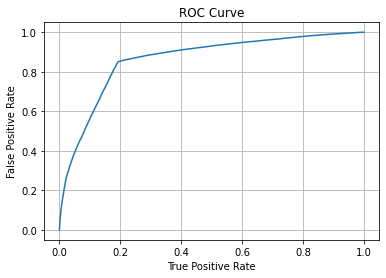

Training set areaUnderROC: 0.862236438290255


In [108]:
trainingSummary = lr_fit_w.stages[-1].summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

### Random Forest Classifier

In [109]:
# import the required libraries
from pyspark.sql import SparkSession
from pyspark.sql import Row
import numpy as np
import pandas as pd
from pyspark.sql.types import *
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
from pyspark.sql import functions as fn
from pyspark.ml import feature, regression, evaluation, Pipeline
import seaborn as sns
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
from sklearn.metrics import classification_report
from pyspark.ml.feature import OneHotEncoder, OneHotEncoderModel, StringIndexer
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


In [110]:
# Create an initial RandomForest model.
rf = RandomForestClassifier(labelCol="label", featuresCol="features",seed=739)

# Train model with Training Data
rfModel = Pipeline(stages=[label_stringIdx,va, rf])

In [111]:
rf_fit = rfModel.fit(training_df)

In [112]:
# Creating the evaluator for our binary classification
evaluator_rfb = BinaryClassificationEvaluator(labelCol='label',metricName='areaUnderROC')

In [113]:
# Prints the accuracy of our binary classification
true_labels=validation_df.toPandas()["Severity"]
evaluator_rfb.evaluate(rf_fit.transform(validation_df))
binary_prediction=rf_fit.transform(validation_df).select("prediction").collect()
binary_true_labels=validation_df.select("Severity").collect()
print("Accuracy:",np.sum(list([int(binary_true_labels[i][0]==binary_prediction[i][0]) for i in range(len(true_labels))]))/len(true_labels))

Accuracy: 0.8088143637032643


In [114]:
print("AUC ROC score:",evaluator_rfb.evaluate(rf_fit.transform(validation_df)))

AUC ROC score: 0.8483796233812081


In [115]:
# create a dataframe to print the feature importance
pd.set_option('display.max_rows', None)
feat_imp_tuned_rf = pd.DataFrame(list(zip([i for i in training_df.columns if i!='Severity'], rf_fit.stages[-1].featureImportances)),
            columns = ['column', 'weight']).sort_values('weight',ascending=False)

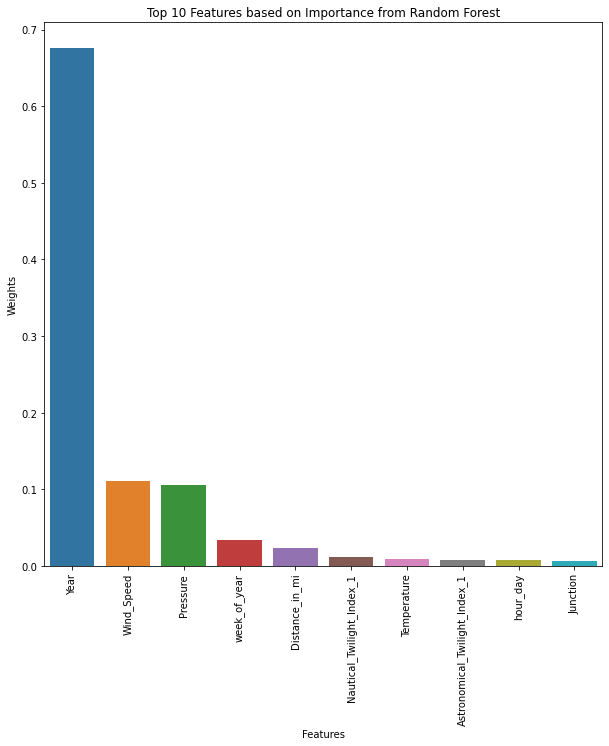

In [116]:
plt.figure(figsize=(10,10))
sns.barplot(x=feat_imp_tuned_rf['column'][:10], y=feat_imp_tuned_rf['weight'][:10],data=feat_imp_tuned_rf)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Weights")
plt.title("Top 10 Features based on Importance from Random Forest");

### Decision Tree

In [117]:
# Create initial Decision Tree Model
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features",seed=739)

# Creates a pipeline
dt_pipe = Pipeline(stages=[label_stringIdx, va, dt])

# Train model with Training Data
dtModel = dt_pipe.fit(training_df)

In [118]:
# Makes prediction from our test set
pred_dt = dtModel.transform(validation_df)

In [119]:
# prints the ROC AUC score
print("ROC AUC:",BinaryClassificationEvaluator(labelCol='label',metricName='areaUnderROC').evaluate(pred_dt))

ROC AUC: 0.7829489078232982


In [120]:
# calculates the accuracy 
BinaryClassificationEvaluator(labelCol='label',metricName='areaUnderROC').evaluate(pred_dt)

binary_prediction=pred_dt.select("prediction").collect()

binary_true_labels=validation_df.select("Severity").collect()

print("Accuracy:",np.sum(list([int(binary_true_labels[i][0]==binary_prediction[i][0]) for i in range(len(true_labels))]))/len(true_labels))

Accuracy: 0.8088143637032643
